# **Sesión 2:** Calibración de Cámara 📷⚙️

## 0. Preparación

In [1]:
import cv2
print("OpenCV should be 4.8.0.76 Current version:", cv2.__version__)
from typing import List
import numpy as np
import imageio.v2 as imageio
import cv2
import copy
import glob
import os

OpenCV should be 4.8.0.76 Current version: 4.8.0


## **Apartado A: Calibración de cámara** (derecha e izquierda)

En este apartado se realiza la calibración de dos cámaras de un sistema estereoscópico. Para ello se trabajará con las imágenes de las carpetas ``left`` y ``right``. En primer lugar se trabajará con la carpeta ``left``. Posteriormente, deberá repetir el proceso con las imágenes en la carpeta ``right``. Ambas carpetas contienen imágenes con las que se calibrarán las cámaras. En ellas aparece el patrón de calibración en diferentes posiciones y orientaciones. Estas imágenes serán los datos de entrada.

Los pasos que deberá seguir para calibrar una cámara son:

1. Defina y ejecute el método para cargar imágenes ``load_images()``.
2. Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.
3. Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``.
4. Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)`` que proporcione las coordenadas 3D de las esquinas del patrón. El sistema de referencia utilizado deberá estar anclado al propio patrón.
5. Utilice ``cv2.calibrateCamera`` para obtener los parámetros de calibración para la cámara izquierda.

### **Tarea A.1:** Defina y ejecute el método para cargar imágenes ``load_images()``.

In [2]:
def load_images(filenames: List[str]) -> List[np.ndarray]:
    return [imageio.imread(filename) for filename in filenames]

# TODO Build a list containing the paths of all images from the left camera
imgs_path = []

for i in range(19):
    if i < 10:
        nombre = f"left_00{i}.jpg"
    else:
        nombre = f"left_0{i}.jpg"

    path = f"..\data\left\{nombre}"
    imgs_path.append(path)

imgs = load_images(imgs_path)

### **Tarea A.2:** Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.

In [3]:
# TODO Find corners with cv2.findChessboardCorners()

# Hemos comprobado que el patrón está formado por 8 filas y 6 columnas de esquinas
size = (8, 6)

# Pasamos las imágenes a escala de grises para poder usar la función cv2.cornerSubPix()
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

# Buscamos el patrón de calibración en cada imagen en escala de grises
corners = [cv2.findChessboardCorners(img, size) for img in imgs_gray]

corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# TODO To refine corner detections with cv2.cornerSubPix() you need to input grayscale images. Build a list containing grayscale images.
corners_refined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else None for i, cor in zip(imgs_gray, corners_copy)]

### **Tarea A.3:** Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``

In [4]:
# Hacemos una copia para no perder las imágenes originales con la función cv2.drawChessboardCorners()
imgs_copy = copy.deepcopy(imgs)

# TODO Use cv2.drawChessboardCorners() to draw the cornes
drawed_corners = [cv2.drawChessboardCorners(img, size, corner, True) for img, corner in zip(imgs_copy, corners_refined) if corner is not None]

# TODO Show images and save when needed
def show_image(img, img_name = "imagen"):
    cv2.imshow(img_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def write_image(img, output_folder, i):
    os.makedirs(output_folder, exist_ok=True) 
    img_name = f"{output_folder}/corners_{i}.jpg"
    cv2.imwrite(img_name, img)

output_folder = "../data/output_left_corners"
os.makedirs(output_folder, exist_ok=True)
for i, img in enumerate(drawed_corners):
    show_image(img)
    write_image(img, output_folder, i)

### **Tarea A.4:** Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)``

In [5]:
# TODO Design the method. It should return a np.array with np.float32 elements
def get_chessboard_points(chessboard_shape, dx, dy):
    cols, rows = chessboard_shape
    matrix = [(i*dx, j*dy, 0) for j in range(rows) for i in range(cols)]
    return np.array(matrix, np.float32)

# TODO You need the points for every image, not just one (consider a list comprehension)
chessboard_points = [get_chessboard_points((8, 6), 30, 30) for _ in range(len(imgs_gray))]


### **Tarea A.5:** Utilice ``cv2.calibrateCamera()`` para obtener los parámetros de calibración para la cámara izquierda

In [6]:
# Filter data and get only those with adequate detections
valid_corners = [cor[1] for cor in corners if cor[0]]
# Convert list to numpy array
valid_corners = np.asarray(valid_corners, dtype=np.float32)

# TODO
img_size = (np.array(imgs_gray)[0].shape[1], np.array(imgs_gray)[0].shape[0])
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, img_size, None, None)
# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[417.77315866   0.         156.33829983]
 [  0.         421.35480199 134.32880063]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-2.13049815e-01  2.86830664e+00  5.90990527e-03 -3.86453734e-03
  -2.23696363e+01]]
Root mean squared reprojection error:
 0.1846287136881559


### **Pregunta A.1:** Repita el proceso (carga de imágenes, detección y comprobación de esquinas, etc.) para la cámara derecha.

In [7]:
# TODO Homework
# Hacemos lo mismo para la cámara derecha

# 1.Cargamos todas las imágenes de la cámara derecha
imgs_path = []

for i in range(19):
    if i < 10:
        nombre = f"right_00{i}.jpg"
    else:
        nombre = f"right_0{i}.jpg"

    path = f"..\data\\right\{nombre}"
    imgs_path.append(path)

imgs = load_images(imgs_path)

# 2.Detectamos las esquinas del patrón y las refinamos

# Hemos comprobado que el patrón está formado por 8 filas y 6 columnas de esquinas
size = (8, 6)

# Pasamos las imágenes a escala de grises para poder usar la función cv2.cornerSubPix()
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

# Buscamos el patrón de calibración en cada imagen en escala de grises
corners = [cv2.findChessboardCorners(img, size) for img in imgs_gray]

corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# Refinamos la detección de las esquinas
corners_refined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else None for i, cor in zip(imgs_gray, corners_copy)]

# 3.Comprobamos la detección de las esquinas mostrando las imágenes con los resultados 

# Hacemos una copia para no perder las imágenes originales con la función cv2.drawChessboardCorners()
imgs_copy = copy.deepcopy(imgs)

drawed_corners = [cv2.drawChessboardCorners(img, size, corner, True) for img, corner in zip(imgs_copy, corners_refined) if corner is not None]

output_folder = "../data/output_right_corners"
os.makedirs(output_folder, exist_ok=True)
for i, img in enumerate(drawed_corners):
    show_image(img)
    write_image(img, output_folder, i)

# 4. Obtenemos los puntos del tablero

chessboard_points = [get_chessboard_points((8, 6), 30, 30) for _ in range(len(imgs_gray))]

# 5. Obtenemos los parámetros de calibración de la cámara derecha

# Filtramos los datos para coger solo los que tienen detecciones adecuadas 
valid_objpoints = []
valid_imgpoints = []

for objp, cor in zip(chessboard_points, corners):
    if cor[0]:  # Solo las que sí detectaron esquinas
        valid_objpoints.append(objp)
        valid_imgpoints.append(cor[1])

print(len(valid_objpoints), len(valid_imgpoints))  # Deben coincidir

# Convert list to numpy array
valid_imgpoints = np.asarray(valid_imgpoints, dtype=np.float32)

# Tamaño de imagen
img_size = (np.array(imgs_gray)[0].shape[1], np.array(imgs_gray)[0].shape[0])

rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(valid_objpoints, valid_imgpoints, img_size, None, None)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)



17 17
Intrinsics:
 [[431.11974701   0.         143.80060613]
 [  0.         431.81832564 135.91696325]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-0.11858684  0.00164086  0.00744943 -0.00649521  0.17890046]]
Root mean squared reprojection error:
 0.14569098303833106


### **Pregunta A.2:** Diferencias entre cv2.findChessboardCorners() y cv2.cornerSubPix()

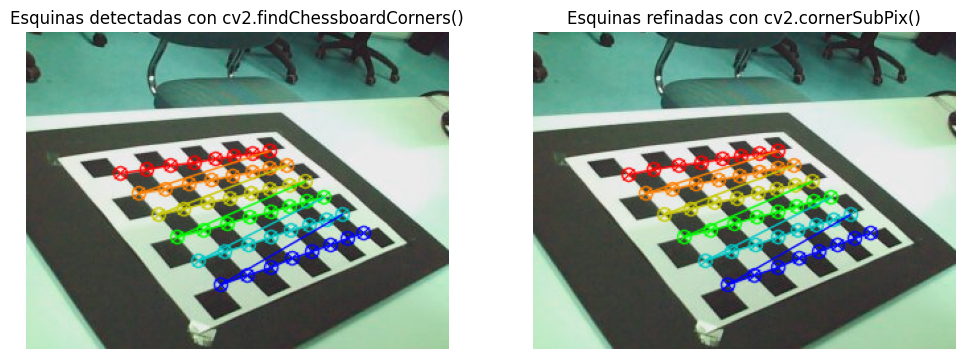

In [16]:
# TODO Homework
import matplotlib.pyplot as plt
# Elegimos una imagen con detección válida (la primera que tenga esquinas)
idx = next(i for i, cor in enumerate(corners) if cor[0])

# Copiamos la imagen original
img_original = copy.deepcopy(imgs[idx])
gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

# Dibujamos las esquinas detectadas con findChessboardCorners()
img_detected = copy.deepcopy(img_original)
cv2.drawChessboardCorners(img_detected, size, corners[idx][1], True)

# Dibujamos las esquinas refinadas con cornerSubPix()
img_refined = copy.deepcopy(img_original)
cv2.drawChessboardCorners(img_refined, size, corners_refined[idx], True)

# Mostramos las dos imágenes lado a lado
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB))
plt.title("Esquinas detectadas con cv2.findChessboardCorners()")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_refined, cv2.COLOR_BGR2RGB))
plt.title("Esquinas refinadas con cv2.cornerSubPix()")
plt.axis('off')

plt.show()

Número de esquinas detectadas: 48
Desplazamiento medio entre detección y refinamiento: 0.1504 píxeles
Desplazamiento máximo: 1.1413 píxeles


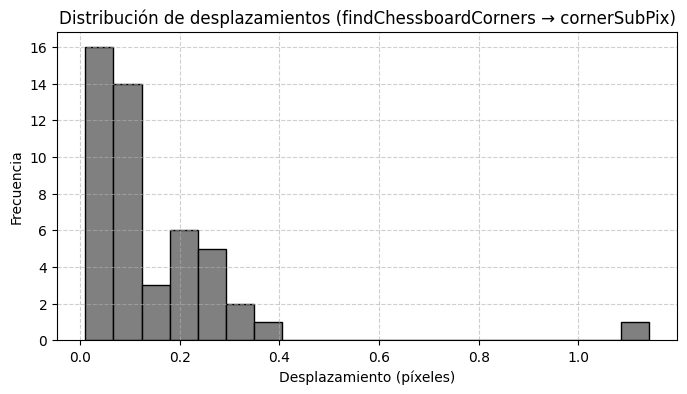

In [17]:
# ------------- COMPARACIÓN MÁS NUMÉRICA DE AMBOS MÉTODOS ------------- #

# Extraemos las coordenadas iniciales y refinadas
pts_initial = corners[idx][1].reshape(-1, 2)
pts_refined = corners_refined[idx].reshape(-1, 2)

# Calculamos el desplazamiento (distancia euclídea) entre puntos
displacements = np.linalg.norm(pts_refined - pts_initial, axis=1)

# Métricas de comparación
mean_disp = np.mean(displacements)
max_disp = np.max(displacements)
num_points = len(displacements)

print(f"Número de esquinas detectadas: {num_points}")
print(f"Desplazamiento medio entre detección y refinamiento: {mean_disp:.4f} píxeles")
print(f"Desplazamiento máximo: {max_disp:.4f} píxeles")

# Histograma de desplazamientos
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(displacements, bins=20, color='gray', edgecolor='black')
plt.title("Distribución de desplazamientos (findChessboardCorners → cornerSubPix)")
plt.xlabel("Desplazamiento (píxeles)")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

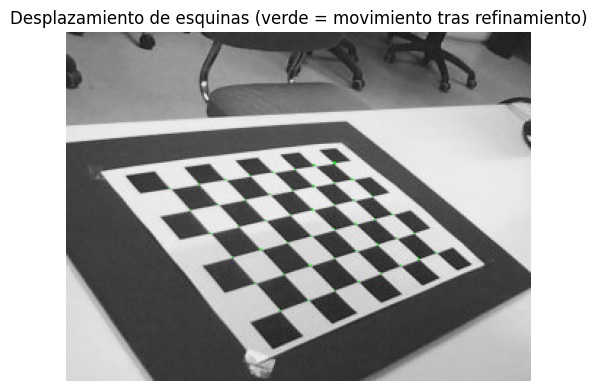

In [18]:
img_diff = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

for p0, p1 in zip(pts_initial, pts_refined):
    p0i, p1i = tuple(np.int32(p0)), tuple(np.int32(p1))
    cv2.arrowedLine(img_diff, p0i, p1i, (0, 255, 0), 1, tipLength=0.4)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_diff, cv2.COLOR_BGR2RGB))
plt.title("Desplazamiento de esquinas (verde = movimiento tras refinamiento)")
plt.axis('off')
plt.show()

### **Pregunta A.3:** Número mínimo de imágenes necesarias para calibrar.

Número total de imágenes válidas disponibles: 17

Resultados de calibración parcial:
 -  3 imágenes → Error RMS = 0.1316
 -  4 imágenes → Error RMS = 0.1354
 -  5 imágenes → Error RMS = 0.1232
 -  6 imágenes → Error RMS = 0.1528
 -  7 imágenes → Error RMS = 0.1207
 -  8 imágenes → Error RMS = 0.1520
 -  9 imágenes → Error RMS = 0.1394
 - 10 imágenes → Error RMS = 0.1511
 - 11 imágenes → Error RMS = 0.1391
 - 12 imágenes → Error RMS = 0.1471
 - 13 imágenes → Error RMS = 0.1519
 - 14 imágenes → Error RMS = 0.1472
 - 15 imágenes → Error RMS = 0.1464
 - 16 imágenes → Error RMS = 0.1473
 - 17 imágenes → Error RMS = 0.1457

Error RMS mínimo alcanzado: 0.1207
Número de imágenes a partir del cual el error se estabiliza (orden de magnitud): ~7 imágenes


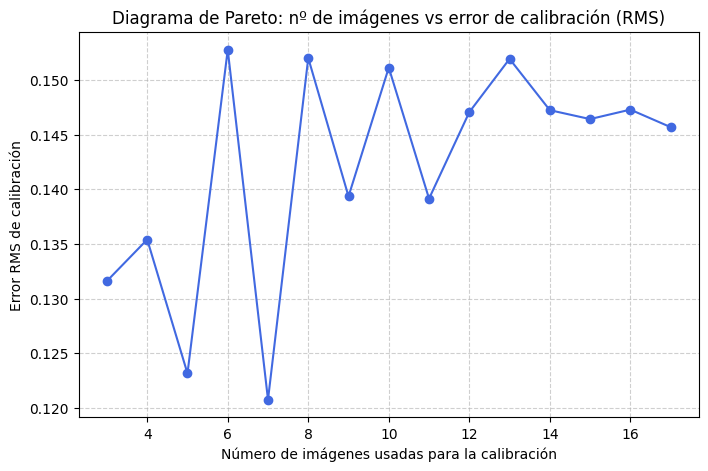

In [ ]:
# TODO Homework

import random

# Aseguramos reproducibilidad
random.seed(42)

# Comprobamos número total de imágenes válidas
num_imgs = len(valid_objpoints)
print(f"Número total de imágenes válidas disponibles: {num_imgs}")

# Guardamos aquí los errores RMS para distintos subconjuntos
rms_errors = []
img_counts = range(3, num_imgs + 1)

for n in img_counts:
    idx = random.sample(range(num_imgs), n)
    objp_subset = [valid_objpoints[i] for i in idx]
    imgp_subset = [valid_imgpoints[i] for i in idx]

    rms, _, _, _, _ = cv2.calibrateCamera(objp_subset, imgp_subset, img_size, None, None)
    rms_errors.append(rms)

# Imprimimos resultados principales
print("\nResultados de calibración parcial:")
for n, rms in zip(img_counts, rms_errors):
    print(f" - {n:2d} imágenes → Error RMS = {rms:.4f}")

# Calculamos el punto de saturación (donde apenas mejora)
min_rms = min(rms_errors)
min_idx = rms_errors.index(min_rms)
optimal_n = list(img_counts)[min_idx]

print("\nError RMS mínimo alcanzado: {:.4f}".format(min_rms))
print("Número de imágenes a partir del cual el error se estabiliza (orden de magnitud): ~{} imágenes".format(optimal_n))

# Dibujamos el diagrama de Pareto
plt.figure(figsize=(8,5))
plt.plot(img_counts, rms_errors, marker='o', linestyle='-', color='royalblue')
plt.title("Diagrama de Pareto: nº de imágenes vs error de calibración (RMS)")
plt.xlabel("Número de imágenes usadas para la calibración")
plt.ylabel("Error RMS de calibración")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## **Apartado B: Corrección de distorsión** (ojo de pez)

En este apartado se trabajará en la corrección de la distorsión debido a lentes de ojo de pez. Primero se calibrará una cámara con este tipo de lente, utilizando las imágenes de la carpeta ``fisheye``. Posteriormente se utilizarán estos parámetros de calibración para corregir la distorsión de una de las imágenes de calibración.

Los pasos que deberá seguir para calibrar una cámara con distorsión de ojo de pez son:

1. Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``.
2. Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.
3. Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero.
4. Defina los argumentos para la función de calibración.
5. Calibre con ``cv2.fisheye.calibrate()``

### **Tarea B.1:** Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``

In [10]:
# TODO Build a list containing the paths of all images from the fisheye camera and load images
fisheye_imgs_path = []
fisheye_imgs = load_images()

TypeError: load_images() missing 1 required positional argument: 'filenames'

### **Tarea B.2:** Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.

In [ ]:
imgs_corners = []
# Parameters for cv2.cornerSubPix()
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

#TODO Complete the required parts of the loop
for img in fisheye_imgs:
    
    # TODO parse arguments to cv2.findChessboardCorners()
    corners = cv2.findChessboardCorners()
    
    # TODO convert image to grayscale to use cv2.cornerSubPix()
    gray_img = cv2.cvtColor()
    refined_corners = cv2.cornerSubPix(gray_img, corners, (3,3), (-1,-1), subpix_criteria)

    # TODO append only those refined_corners with proper detections
    imgs_corners.append(refined_corners)

### **Tarea B.3:** Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero

In [ ]:
# TODO Define the chessboard dimensions and the lenght of the squares (in [mm])
chessboard_dims = (None, None)
length = None
# TODO You need the points for every image, not just one (consider a list comprehension)
fisheye_chessboard_points = get_chessboard_points(chessboard_dims, length, length)

### **Tarea B.4:** Defina los argumentos para la calibración

In [ ]:
# Parameters for cv2.fisheye.calibrate()
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
intrinsics = np.zeros((3, 3))
distortion = np.zeros((4, 1))
rotations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]
traslations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]


### **Tarea B.5:** Calibración

In [ ]:
rms, _, _, _, _ = \
cv2.fisheye.calibrate(fisheye_chessboard_points, imgs_corners, gray_img.shape[::-1], intrinsics, distortion, rotations, traslations, calibration_flags, subpix_criteria)

In [ ]:
# Show intrinsic matrix and distortion coefficients values
print(intrinsics)
print(distortion)

### **Pregunta B.1:** Corrija la distorsión de las 2 primeras imágenes de la carpeta ``fisheye``

In [ ]:
# TODO Search in the documentation to define 'dim'
dim = None
map1, map2 = cv2.fisheye.initUndistortRectifyMap(intrinsics, distortion, np.eye(3), intrinsics, dim, cv2.CV_16SC2)

In [ ]:
# TODO Homework: correct distortion using cv2.remap()